This week, let's see a simple example how we can detect the periodic signals within the data. This is usually a quite interesting problem in many cases. Here, we will use a simple example from the readings of a thermometer in an office building. The thermometer measures the inside temperature every half hour for four months in Fahrenheit. Our goal is to find the periodic signal within it, that is when some pattern in the signal repeat. 

Let's first load the data from the mat file.  

In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft, arange, signal
plt.style.use('seaborn-poster')
%matplotlib inline

In [2]:
# load the data
data = sio.loadmat('./data/officetemp.mat')

In [3]:
# convert to numpy array
temp = np.array([x[0] for x in data['temp']])

# convert the temp from Fahrenheit to Celsius
tempC = (temp - 32.)*5./9.

# we remove the mean of the signal to create a signal oscillating around 0
tempNorm = tempC - np.mean(tempC)

Since the data measured every half hour, we can either work in hours or days. I like to work in days, and the sampling rate is thus 2 measurements/hour × 24 hours/day = 48 measurements/day. Then we can create the timestamp for each measurement, and plot the data. 

In [4]:
# this is sampling rate, 48 samples/day
fs = 2*24

# create timestamp that start with 1, this is means
# our day start with day 1. 
t = arange(len(temp))/float(fs) + 1

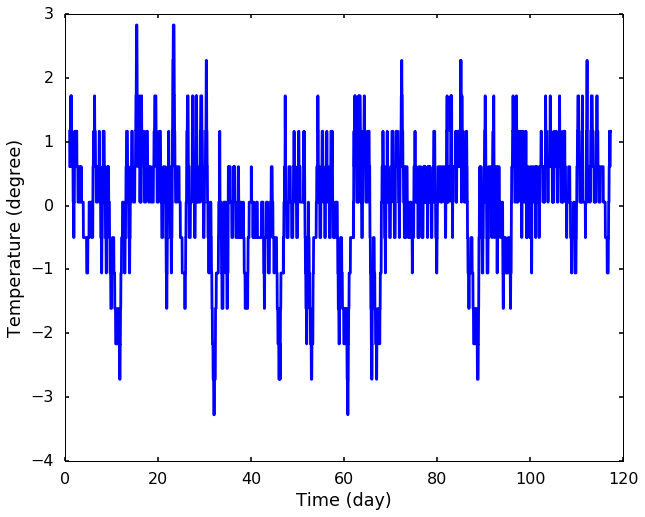

In [5]:
# let's plot the data
plt.figure(figsize = (10, 8))
plt.plot(t, tempNorm)
plt.xlabel('Time (day)')
plt.ylabel('Temperature (degree)')

From the above figure, we can see the signal does seem to have some pattern repeat, but we can not tell how it repeat. This is actually our main goal: to get the period of the repeating signals. Let's first see a simple method, which is called zero crossings. It is a very simple way to estimate the frequency by counting the number of times the signal across the baseline, in this case 0, since we removed the mean of the signal. Then we can get a sense how the signal repeat. This technique is very simple and inexpensive but is not very accurate. It is mostly used to get a rough fundamental frequency of the signal. 

### Zero crossings

In [6]:
from matplotlib.mlab import find
def freq_zero_crossing(sig, fs):
    """
    Frequency estimation from zero crossing method
    sig - input signal
    fs - sampling rate
    
    return: 
    dominant period
    """
    # Find the indices where there's a crossing
    indices = find((sig[1:] >= 0) & (sig[:-1] < 0))

    # Let's calculate the real crossings by interpolate
    crossings = [i - sig[i] / (sig[i+1] - sig[i]) for i in indices]
    
    # Let's get the time between each crossing
    # the diff function will get how many samples between each crossing
    # we divide the sampling rate to get the time between them
    delta_t = np.diff(crossings) / fs
    
    # Get the mean value for the period
    period = np.mean(delta_t)
    
    return period

In [7]:
period_from_zero_crossing = freq_zero_crossing(tempNorm, fs)
print('The period estimation is %.1f days'%(period_from_zero_crossing))

The period estimation is 1.4 days


We can see the estimation we got from the zero crossings is not so good, it is even difficult to explain why there is a signal repeating every 1.4 days. Well, this is just a rough estimation, and let's use a more popular and accurate method to estimate it - [Fourier Transform](https://en.wikipedia.org/wiki/Fourier_transform). We use the periodogram from scipy to get the spectrum of the signal below. and plot the results.  

### Frequency content

In [8]:
# get the frequency and spectrum
f, Pxx = signal.periodogram(tempNorm, fs = fs, window='hanning', scaling='spectrum')

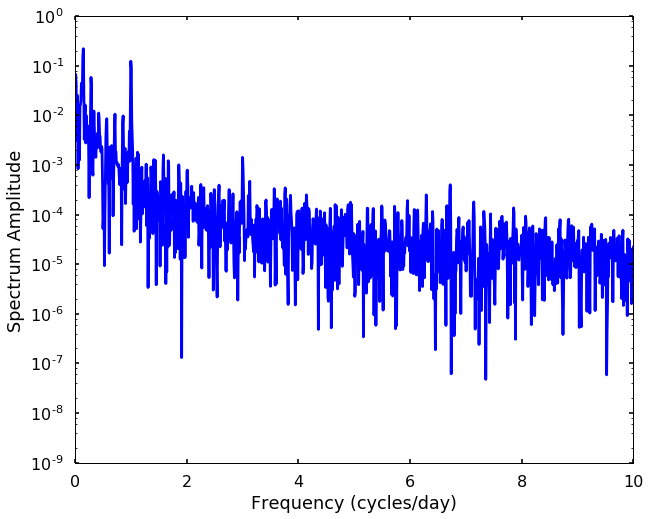

In [9]:
plt.figure(figsize = (10, 8))
plt.plot(f, Pxx)
plt.xlim(0, 10)
plt.yscale('log')
plt.xlabel('Frequency (cycles/day)')
plt.ylabel('Spectrum Amplitude')

From the spectrum, we can see some peaks, the corresponding frequency indicates the periodic signals, and how strong this frequency signal is showing in the spectrum amplitude. The higher the peak, the stronger of this signal repeating itself. Let's print out the top 5 peaks, and see how many days corresponding to them. After we got these peaks, we need interpret the results. We can see the 7 day peak is the strongest peak, which means for every 7 days the signal will repeat. 1 day peak is also very strong, there are two peaks associated with it, this is due to the leakage of the spectrum that we talked before in the [taper blog](http://qingkaikong.blogspot.com/2016/10/signal-processing-why-do-we-need-taper.html). The 116 day is about the total length of the signal, and the 3.5 days is the half week. All these peaks seem correct, and can be explained using common sense.   

In [10]:
# print the top 6 period in the signal
for amp_arg in np.argsort(np.abs(Pxx))[::-1][1:6]:
    day = 1 / f[amp_arg]
    print(day)

7.27083333333
1.00287356322
0.994301994302
116.333333333
3.52525252525


### Autocorrelation

Another common method to detect the periodic signal is to use [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation). This is a simple method in the time domain that you shift the signal with a time lag and calculate the correlation with the original signal (or we can simply add the two signal up to get a number, and then we can divide the largest number to scale the value to -1 to 1). If there are any periodic signal, after certain time lag, we should see the correlation have a significant increase, and a simple example is shown in the following picture. On the left, we shift the same signal to the right (shown as the red signal), and on the right, it is the autocorrelation we calculate. We notice that the autocorrelation have a downward ramp, since the number of points added together to produce the value are reduced at each successive shift. The peaks in the autocorrelation figure are showing the periodic signal and its corresponding time lag (that is how much we shift the signal to get this correlation). Let's try to create an animation [next week](http://qingkaikong.blogspot.com/2017/01/signal-processing-how-autocorrelation.html) to show how autocorrelation works ^)^

![jpg](./figures/figure3.png) 

In [11]:
from statsmodels import api as sm

In [12]:
# get the autocorrelation coefficient
acf = sm.tsa.acf(tempNorm, nlags=len(tempNorm))

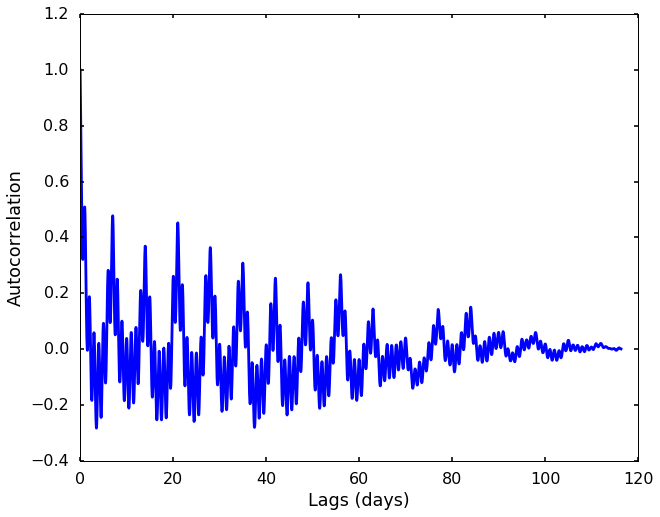

In [13]:
plt.figure(figsize = (10, 8))
lag = arange(len(tempNorm)) / 2. / 24.
plt.plot(lag, acf)
plt.xlim((0, 120))
plt.xlabel('Lags (days)')
plt.ylabel('Autocorrelation')

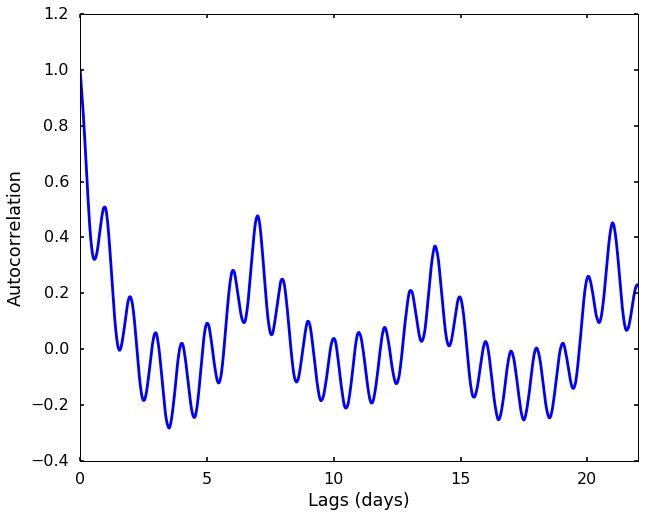

In [14]:
plt.figure(figsize = (10, 8))
plt.plot(lag, acf)
plt.xlim((0, 22))
plt.xlabel('Lags (days)')
plt.ylabel('Autocorrelation')

From the two autocorrelation figures, we can see the clearest peaks are at 1 day, 7 days, 14 days, 21 days, ... Therefore, 1 day and 7 days are the period of the repeating signal in the data. 

There are also many other methods to identify the periodic signals in the data, and we will add them in the future.   

### References

https://www.mathworks.com/examples/signal/mw/signal-ex69123038-find-periodicity-using-autocorrelation
https://www.mathworks.com/examples/signal/mw/signal-ex50284156-find-periodicity-using-frequency-analysis